# Sistemas de Machine Learning - Tarea 7
Elige uno de los ejemplos de GAN disponibles en https://keras.io/examples/generative/ y realiza algunos cambios en el código fuente.

Por ejemplo, estos cambios pueden referirse a los parámetros de los modelos, las imágenes de referencia que se utilizan o la arquitectura de los modelos (número de capas, neuronas por capa…).

Documenta en tu cuaderno Colab las modificaciones que has hecho y las diferencias que has obtenido respecto al sistema original.

### Cambios que realizaré en el código:

- Cambiar el set de datos de MINST a CIFAR-10, se trata de un conjunto de datos de 10 categorías como perros, gatos, coches, etc.
- Modificar el tamaño de las imágenes.
- Modificar parámetros del modelo.
- Modificar número de canales por el RGB.
- Cambiar el número de neuronas por capa.
- Cambiar el número de capas.
- Otro cambio

Explica les diferències entre els resultats del codi modificat i l’original

# Conditional GAN

**Author:** [Sayak Paul](https://twitter.com/RisingSayak)<br>
**Date created:** 2021/07/13<br>
**Last modified:** 2024/01/02<br>
**Description:** Training a GAN conditioned on class labels to generate handwritten digits.

In [1]:
!pip install -q git+https://github.com/tensorflow/docs

  Preparing metadata (setup.py) ... done


## Imports

In [2]:
import keras

from keras import layers
from keras import ops
from tensorflow_docs.vis import embed
import tensorflow as tf
import numpy as np
import imageio

## Constants and hyperparameters

In [3]:
batch_size = 64
num_channels = 3 # Usamos 3 canales por el RGB
num_classes = 10
image_size = 32 # Las imágenes de CIFAR-10 son de 32x32
latent_dim = 128

## Loading the CIFAR-10 dataset and preprocessing it

In [4]:
# We'll use all the available examples from both the training and test
# sets.
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data() # Cargamos el dataset CIFAR-10
all_images = np.concatenate([x_train, x_test])
all_labels = np.concatenate([y_train, y_test])

# Scale the pixel values to [0, 1] range, add a channel dimension to
# the images, and one-hot encode the labels.

all_images = all_images.astype("float32") / 255.0 # En caso de usar "sigmoid" en el generador como funcion de activación
# all_images = (all_images - 127.5) / 127.5 # En caso de usar "tahn" en el generador como funcion de activación
all_labels = keras.utils.to_categorical(all_labels, num_classes)

# Create tf.data.Dataset.
dataset = tf.data.Dataset.from_tensor_slices((all_images, all_labels))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

print(f"Shape of training images: {all_images.shape}")
print(f"Shape of training labels: {all_labels.shape}")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step
Shape of training images: (60000, 32, 32, 3)
Shape of training labels: (60000, 10)


## Calculating the number of input channel for the generator and discriminator

In a regular (unconditional) GAN, we start by sampling noise (of some fixed
dimension) from a normal distribution. In our case, we also need to account
for the class labels. We will have to add the number of classes to
the input channels of the generator (noise input) as well as the discriminator
(generated image input).

In [5]:
generator_in_channels = latent_dim + num_classes
discriminator_in_channels = num_channels + num_classes
print(generator_in_channels, discriminator_in_channels)

138 13


## Creating the discriminator and generator

The model definitions (`discriminator`, `generator`, and `ConditionalGAN`) have been
adapted from [this example](https://keras.io/guides/customizing_what_happens_in_fit/).

In [6]:
# Create the discriminator.
discriminator = keras.Sequential(
    [
        keras.layers.InputLayer((32, 32, discriminator_in_channels)),
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Dropout(0.3),  # Evita overfitting

        layers.Conv2D(128, (5, 5), strides=(2, 2), padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.BatchNormalization(),

        layers.Conv2D(256, (5, 5), strides=(2, 2), padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.BatchNormalization(),

        layers.Flatten(),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)

# Create the generator.
generator = keras.Sequential(
    [
        keras.layers.InputLayer((generator_in_channels,)),
        # We want to generate 128 + num_classes coefficients to reshape into a
        # 7x7x(128 + num_classes) map.
        layers.Dense(8 * 8 * 256),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Reshape((8, 8, 256)),

        layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.BatchNormalization(),

        layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.BatchNormalization(),

        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.BatchNormalization(),

        layers.Conv2D(32, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.BatchNormalization(),

        layers.Conv2D(3, (3, 3), padding="same", activation="sigmoid"),
    ],
    name="generator",
)

## Creating a `ConditionalGAN` model

In [7]:

class ConditionalGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.seed_generator = keras.random.SeedGenerator(1337)
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        # Unpack the data.
        real_images, one_hot_labels = data

        # Add dummy dimensions to the labels so that they can be concatenated with
        # the images. This is for the discriminator.
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = ops.repeat(
            image_one_hot_labels, repeats=[image_size * image_size]
        )
        image_one_hot_labels = ops.reshape(
            image_one_hot_labels, (-1, image_size, image_size, num_classes)
        )

        # Sample random points in the latent space and concatenate the labels.
        # This is for the generator.
        batch_size = ops.shape(real_images)[0]
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )
        random_vector_labels = ops.concatenate(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Decode the noise (guided by labels) to fake images.
        generated_images = self.generator(random_vector_labels)

        # Combine them with real images. Note that we are concatenating the labels
        # with these images here.
        fake_image_and_labels = ops.concatenate(
            [generated_images, image_one_hot_labels], -1
        )
        real_image_and_labels = ops.concatenate([real_images, image_one_hot_labels], -1)
        combined_images = ops.concatenate(
            [fake_image_and_labels, real_image_and_labels], axis=0
        )

        # Assemble labels discriminating real from fake images.
        labels = ops.concatenate(
            [ops.ones((batch_size, 1)), ops.zeros((batch_size, 1))], axis=0
        )

        # Train the discriminator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space.
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )
        random_vector_labels = ops.concatenate(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Assemble labels that say "all real images".
        misleading_labels = ops.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_vector_labels)
            fake_image_and_labels = ops.concatenate(
                [fake_images, image_one_hot_labels], -1
            )
            predictions = self.discriminator(fake_image_and_labels)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }


## Training the Conditional GAN

In [48]:
cond_gan = ConditionalGAN(
    discriminator=discriminator, generator=generator, latent_dim=latent_dim
)
cond_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

cond_gan.fit(dataset, epochs=75)

Epoch 1/75
938/938 ━━━━━━━━━━━━━━━━━━━━ 125s 122ms/step - d_loss: 0.8978 - g_loss: 0.8517
Epoch 2/75
938/938 ━━━━━━━━━━━━━━━━━━━━ 109s 117ms/step - d_loss: 0.7275 - g_loss: 0.8800
Epoch 3/75
938/938 ━━━━━━━━━━━━━━━━━━━━ 110s 117ms/step - d_loss: 0.7138 - g_loss: 0.8153
Epoch 4/75
938/938 ━━━━━━━━━━━━━━━━━━━━ 142s 117ms/step - d_loss: 0.7466 - g_loss: 0.8322
Epoch 5/75
938/938 ━━━━━━━━━━━━━━━━━━━━ 142s 117ms/step - d_loss: 0.7161 - g_loss: 0.8929
Epoch 6/75
938/938 ━━━━━━━━━━━━━━━━━━━━ 142s 117ms/step - d_loss: 0.6901 - g_loss: 0.9076
Epoch 7/75
938/938 ━━━━━━━━━━━━━━━━━━━━ 110s 117ms/step - d_loss: 0.6951 - g_loss: 0.8338
Epoch 8/75
938/938 ━━━━━━━━━━━━━━━━━━━━ 109s 117ms/step - d_loss: 0.7035 - g_loss: 0.9653
Epoch 9/75
938/938 ━━━━━━━━━━━━━━━━━━━━ 142s 117ms/step - d_loss: 0.6294 - g_loss: 1.0285
Epoch 10/75
938/938 ━━━━━━━━━━━━━━━━━━━━ 110s 117ms/step - d_loss: 0.6650 - g_loss: 1.0976
Epoch 11/75
938/938 ━━━━━━━━━━━━━━━━━━━━ 110s 117ms/step - d_loss: 0.6411 - g_loss: 0.9955
Epoch 12

## Interpolating between classes with the trained generator

In [78]:
import matplotlib.pyplot as plt

# We first extract the trained generator from our Conditional GAN.
trained_gen = cond_gan.generator

# Choose the number of intermediate images that would be generated in
# between the interpolation + 2 (start and last images).
num_interpolation = 9  # @param {type:"integer"}

# Sample noise for the interpolation.
interpolation_noise = keras.random.normal(shape=(1, latent_dim))
interpolation_noise = ops.repeat(interpolation_noise, repeats=num_interpolation)
interpolation_noise = ops.reshape(interpolation_noise, (num_interpolation, latent_dim))


def interpolate_class(first_number, second_number):
    # Convert the start and end labels to one-hot encoded vectors.
    first_label = keras.utils.to_categorical([first_number], num_classes)
    second_label = keras.utils.to_categorical([second_number], num_classes)
    first_label = ops.cast(first_label, "float32")
    second_label = ops.cast(second_label, "float32")

    # Calculate the interpolation vector between the two labels.
    percent_second_label = ops.linspace(0, 1, num_interpolation)[:, None]
    percent_second_label = ops.cast(percent_second_label, "float32")
    interpolation_labels = (
        first_label * (1 - percent_second_label) + second_label * percent_second_label
    )

    # Combine the noise and the labels and run inference with the generator.
    noise_and_labels = ops.concatenate([interpolation_noise, interpolation_labels], 1)
    fake_images = trained_gen.predict(noise_and_labels)
    fake_images = ops.reshape(fake_images, (num_interpolation, 32, 32, 3))
    fake_images = fake_images.numpy()
    return fake_images


start_class = 2  # @param {type:"slider", min:0, max:9, step:1}
end_class = 2  # @param {type:"slider", min:0, max:9, step:1}

fake_images = interpolate_class(start_class, end_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Here, we first sample noise from a normal distribution and then we repeat that for
`num_interpolation` times and reshape the result accordingly.
We then distribute it uniformly for `num_interpolation`
with the label identities being present in some proportion.


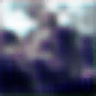

In [79]:
fake_images *= 255.0
converted_images = fake_images.astype(np.uint8)
converted_images = ops.image.resize(converted_images, (96, 96)).numpy().astype(np.uint8)
imageio.mimsave("animation.gif", converted_images, fps=1)
embed.embed_file("animation.gif")

### Orden de categorías de CIFAR-10

0 - Aviones ✈️  
1 - Automóviles 🚗  
2 - Pájaros 🐦  
3 - Gatos 🐱  
4 - Ciervos 🦌  
5 - Perros 🐶  
6 - Ranas 🐸  
7 - Caballos 🐴  
8 - Barcos ⛵  
9 - Camiones 🚛  

Después de realizar varias pruebas, he logrado comprender mejor cómo funcionan las GAN. El primer paso fue cambiar el dataset a CIFAR-10 y verificar que el modelo funcionara correctamente con este nuevo conjunto de datos. Una vez realizado este cambio, antes de modificar el número de capas y otros parámetros, los resultados fueron los siguientes:

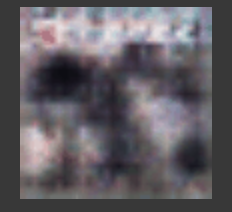

Claramente no es una imagen reconocible, por lo que a partir de este punto decidí realizar una serie de pruebas.v


- **Primera prueba:** En esta prueba, modifiqué el código de entrenamiento para añadir más capas tanto al discriminator como al generator. Específicamente, añadí una capa adicional a cada uno, aumentando su número total a 3 capas. Además, cambié el número de epochs de 20 a 60, ya que esperaba que más iteraciones ayudaran a mejorar la calidad de las imágenes generadas. También decidí modificar la función de activación del generador a “tanh”, ya que su salida está en el rango de [-1,1], en lugar de [0,1] como con la función sigmoid. Esto podría ayudar a obtener imágenes generadas más realistas, dado que no estamos buscando una clasificación exacta.

Después de entrenar el modelo durante un tiempo considerable, el resultado fue el siguiente:

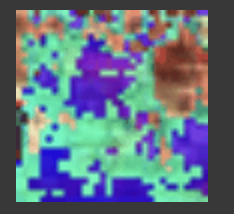

De nuevo una imágen irreconocible, incluso diría que se pueden diferenciar mejor las formas en la anterior.

De nuevo, la imagen generada no era reconocible. Incluso diría que las formas en la imagen anterior eran algo más diferenciables. Esto me llevó a plantearme qué podría estar fallando, y recordé el concepto de “Convergencia” que había visto en los apuntes:
"*Si la GAN continua entrenant més enllà del punt en què el discriminador està donant una retroalimentació completament aleatòria, aleshores el generador comença a entrenar amb la retroalimentació no desitjada i la seva pròpia qualitat pot col·lapsar-se.*"

- **Segunda prueba:** Pensé que este concepto podría explicar lo que estaba sucediendo. No estaba seguro si el problema provenía del número de capas o del número de epochs, así que decidí reducir las capas del discriminador para evitar que fuera demasiado exigente. Este fue el resultado:

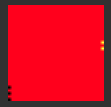

Una vez más no conseguía lo esperado. Por lo que seguí haciendo cambios.

- **Tercera prueba:** Decidí volver a algunos parámetros que tenía al principio debido a que la imagen estaba demasiado deformada. Volví a usar sigmoid como función de activación en el generador y reduje los epochs a 30. También decidí regresar a tener 3 capas en el discriminador, igualando las dos redes en cuanto a su número de capas. Finalmente, reduje el learning rate a 0.0002.

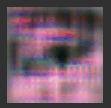

Después de hacer algunos ajustes más, los resultados seguían sin mejorar. A continuación, decidí agregar estas capas adicionales al generador para intentar mejorar la capacidad de aprendizaje del modelo y evitar el sobreajuste:
```
layers.Flatten(),
layers.Dropout(0.3),
```

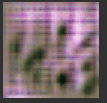

Seguidamente, cambié el tamaño de las capas del generador a 5x5 y, sorprendentemente, observé una mejora. Aunque la imagen seguía siendo irreconocible, la calidad había mejorado en comparación con los intentos anteriores.

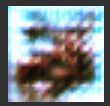

Como prueba final, volví a probar con epoch igual a 75 y modifiqué únicamente el learning rate del generador a 0.0003 manteniendo el discriminador a 0.0001, con la idea de hacer que aprenda más rápido. Para evaluar si esto funcionaba, revisé el valor de *g_loss* (la pérdida del generador). Vi que, efectivamente, la pérdida era menor que en entrenamientos anteriores, pero aún así parece que no fue suficiente para conseguir buenos resultados.

La siguiente imagen muestra el resultado actual, que es la última prueba realizada en el cuaderno.

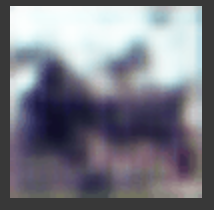

# Conclusión

Después de tantas pruebas y ajustes, la verdad es que no he logrado generar imágenes claras y 100% reconocibles. La cosa no acababa de mejorar, pero he aprendido bastante con las pruebas que he hecho. Aunque los resultados no son los esperados, ajustar los parámetros me ha ayudado a entender mejor cómo funciona todo.

Sé que este tipo de experimentación es clave para mejorar, y aunque no obtuve lo que quería, ahora entiendo mejor los conceptos de las GAN.

De todas maneras estaré encantado y muy interesado de escuchar feedback sobre las posibles causas que no he tenido en cuenta para conseguir mejoras en el modelo.
